# Analyse des données de valeurs foncières (2017-2020)

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio; pio.renderers.default='notebook'
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.api import OLS
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

### Récupération des .csv

In [2]:
# Import des .csv via une list comprehension
listecsv = ['dvf_2017','dvf_2018','dvf_2019','dvf_2020']
file_name = '{}.csv'
df_list = []
df = pd.concat([pd.read_csv(file_name.format(i)) for i in listecsv])

In [ ]:
df.shape

In [ ]:
df.head()

### Feature engineering

In [3]:
#Suppression des colonnes suivantes
del df['Code commune']
del df['Prefixe de section']
del df['Section']
del df['Code voie']
del df['Voie']
del df['No voie']
del df['Type de voie']

In [4]:
# Renommage de la colonne "Unnamed 0" en "numero"
df.rename(columns={'Unnamed: 0': 'numero'}, inplace=True)

In [5]:
# Ajout d'un zéro pour les départements concernés
df["Code departement"] = df["Code departement"].apply(lambda x: '0' + str(x) if len(str(x)) < 2 else str(x))

In [6]:
# Remplacement des NaN de Type local par "Autres"
df['Type local'] = df['Type local'].replace(np.nan, "Autres")

In [7]:
df['Date mutation'] = pd.to_datetime(df['Date mutation'], errors='coerce')

In [8]:
# Création des colonnes Annee / Mois / Jour
df['Annee'] = pd.DatetimeIndex(df['Date mutation']).year
df['Mois'] = pd.DatetimeIndex(df['Date mutation']).month
df['Jour'] = pd.DatetimeIndex(df['Date mutation']).day

In [9]:
df.head()

,numero,No disposition,Date mutation,Nature mutation,Valeur fonciere,Code postal,Commune,Code departement,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain,Annee,Mois,Jour
0,0,1,2017-02-01,Vente,27000.0,01000,BOURG-EN-BRESSE,01,Appartement,37.0,2.0,NaN,NaN,2017,2,1
1,1,1,2017-05-01,Vente,115000.0,01960,PERONNAS,01,Autres,NaN,NaN,AB,788.0,2017,5,1
2,2,1,2017-06-01,Vente,1.0,01380,SAINT-CYR-SUR-MENTHON,01,Autres,NaN,NaN,P,42.0,2017,6,1
3,3,1,2017-06-01,Vente,1.0,01380,SAINT-CYR-SUR-MENTHON,01,Autres,NaN,NaN,P,77.0,2017,6,1
4,4,1,2017-06-01,Vente,1.0,01380,SAINT-CYR-SUR-MENTHON,01,Autres,NaN,NaN,P,94.0,2017,6,1


### Exploratory Data Analysis - EDA

#### Valeurs foncières en fonction de l'année : 

In [ ]:
fig = px.sunburst(df, path=['Annee'], values = 'Valeur fonciere',
                  color_discrete_sequence=px.colors.diverging.Spectral,
                  title = 'Part relative de la valeur foncière totale en fonction des années')
fig.update_traces(textinfo="label+percent entry")
fig.show()

#### Type de mutations par année :

In [ ]:
fig = px.sunburst(df, path=['Annee','Nature mutation'], values = 'Valeur fonciere',
                  color_discrete_sequence=px.colors.diverging.Spectral,
                  title = 'Part relative du type de mutations en fonction des années')
fig.update_traces(textinfo="label+percent entry")
fig.show()

#### Nombre de mutation par département :

In [ ]:
fig = px.histogram(df, x="Code departement",y="numero",histfunc='count')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#### Type de local par année :

In [ ]:
fig = px.histogram(df, x='Type local', y = 'numero', color = 'Type local',
                   histfunc = 'count', facet_col='Annee', facet_col_wrap=2)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

### Focus : métropole lyonnaise

#### Type de mutations par année dans le Rhône (69) :

In [9]:
df_rhone = df[df['Code departement'] == '69']

In [ ]:
df_rhone.head()

In [ ]:
fig = px.sunburst(df_rhone, path=['Annee','Commune','Nature mutation'], values = 'Valeur fonciere',
                  color_discrete_sequence=px.colors.diverging.Spectral)
fig.update_traces(textinfo="label+percent entry")
fig.show()

#### Evolution du nombre de mutations sur Lyon (2017-2020) : 

In [10]:
df_lyon = df_rhone[df_rhone['Commune'].str.contains("^LYON")]

In [25]:
df_grouped = df_lyon.groupby(['Commune','Annee'],as_index=False).count()

In [ ]:
px_plot = px.line(df_grouped, x='Annee', y='numero', color = 'Commune',
                  color_discrete_sequence=px.colors.qualitative.Bold,markers=True)
px_plot.update_traces(marker={'size': 12})
px_plot

### TSA

#### Evolution du nombre de mutations à lyon :

In [ ]:
fig = px.histogram(df_lyon, x="Date mutation",y="numero",histfunc='count', color = 'Commune',
                   facet_col='Commune', facet_col_wrap=3)
fig.show()

#### Recherche de saisonnalité : 

In [ ]:
fig = px.histogram(df_lyon, x="Mois",y="numero",histfunc='count', color = 'Commune',
                   facet_col='Commune', facet_col_wrap=3)
fig.show()

In [ ]:
fig = px.histogram(df_lyon, x="Jour",y="numero",histfunc='count', color = 'Commune',
                   facet_col='Commune', facet_col_wrap=3)
fig.show()

#### Preparation des donnees TSA : grouper les valeurs foncieres de vente par jour

In [11]:
df_lyon_vente = df_lyon[df_lyon['Nature mutation'].str.contains("Vente")]

In [12]:
df_lyon_vente.head()

,numero,No disposition,Date mutation,Nature mutation,Valeur fonciere,Code postal,Commune,Code departement,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain,Annee,Mois,Jour
2237860,237868,1,2017-05-01,Vente,578800.0,69001,LYON 1ER,69,Appartement,20.0,1.0,NaN,NaN,2017,5,1
2237861,237869,1,2017-05-01,Vente,578800.0,69001,LYON 1ER,69,Appartement,100.0,4.0,NaN,NaN,2017,5,1
2237862,237870,1,2017-03-01,Vente,569800.0,69004,LYON 4EME,69,Dependance,0.0,0.0,NaN,NaN,2017,3,1
2237863,237871,1,2017-03-01,Vente,569800.0,69004,LYON 4EME,69,Appartement,138.0,5.0,NaN,NaN,2017,3,1
2237864,237872,1,2017-05-01,Vente,240000.0,69002,LYON 2EME,69,Appartement,43.0,2.0,NaN,NaN,2017,5,1


In [13]:
df_tsa_sum = df_lyon_vente.groupby('Date mutation',as_index= False)['Valeur fonciere'].sum()

#### Evolution de la valeur foncière "vente"

In [15]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(x=df_tsa_sum["Date mutation"],y=df_tsa_sum["Valeur fonciere"],showlegend=False,mode="lines",line=dict(color="#2271B3")),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=df_tsa_sum["Date mutation"],y=df_tsa_sum["Valeur fonciere"],showlegend=False,mode="lines",line=dict(color="#2271B3")),
    row=2, col=1)

fig.update_yaxes(title_text="Echelle d'origine", row=1, col=1)
fig.update_yaxes(title_text="Echelle logarithmique", type="log", row=2, col=1)
fig.update_layout(height=600, width=800, title_text="Evolution de la valeur foncière lyonnaise entre 2017 et 2020")
fig.show() 

Pertinence de l'échelle logarithmique !

#### Tendance vs. Données

In [18]:
notrend = detrend(df_tsa_sum['Valeur fonciere'])
df_tsa_sum["notrend"] = notrend

fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(x=df_tsa_sum["Date mutation"],y=df_tsa_sum["Valeur fonciere"],showlegend=False,mode="lines",line=dict(color="#2271B3")),
    row=1, col=1)
fig.add_trace(
    go.Scatter(x=df_tsa_sum["Date mutation"],y=df_tsa_sum["notrend"],showlegend=False,mode="lines",line=dict(color="#E55137")),
    row=1, col=1)

fig.update_yaxes(title_text="Echelle d'origine", row=1, col=1)
fig.update_layout(height=600, width=800, title_text="Evolution de la valeur foncière lyonnaise et de la tendance entre 2017 et 2020")
fig.show() 

#### Difference entre la valeur n-1 et n 

In [21]:
df_tsa_sum["diff"] = np.nan
df_tsa_sum.loc[1:, "diff"] = (df_tsa_sum.iloc[1:, 1].values - df_tsa_sum.iloc[:len(df_tsa_sum)-1, 1].values)
df_tsa_sum.head()

,Date mutation,Valeur fonciere,notrend,diff
0,2017-01-02,11322105.00,-4.324150e+07,NaN
1,2017-01-03,12974726.60,-4.179500e+07,1652621.60
2,2017-01-04,148000.00,-5.482786e+07,-12826726.60
3,2017-01-06,17594710.66,-3.758728e+07,17446710.66
4,2017-01-07,530000.00,-5.485812e+07,-17064710.66


#### Autocorrélation / Autocorrélation partielle

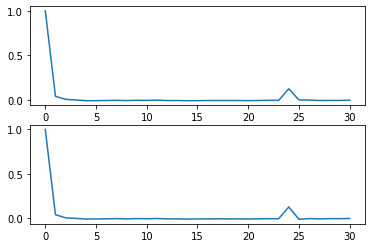

In [36]:
cor = acf(df_tsa_sum.notrend)
pcor = pacf(df_tsa_sum.notrend)
plt.subplot(2, 1, 1)
plt.plot(cor)
plt.subplot(2, 1, 2)
plt.plot(pcor)

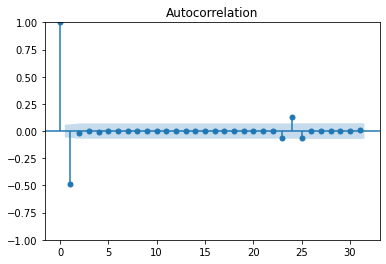

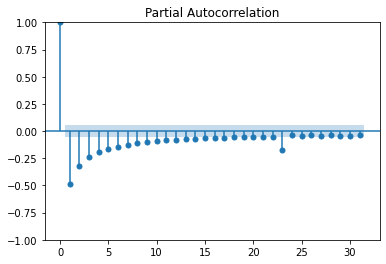

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df_tsa_sum["diff"].iloc[0] = 0
plot_acf(df_tsa_sum["diff"])
plot_pacf(df_tsa_sum["diff"])
plt.show()

#### Tendance par regression linéaire de Y sur le temps

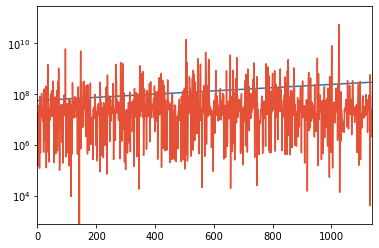

In [20]:
y = df_tsa_sum['Valeur fonciere']
X = np.ones((len(y), 2))
X[:,1] = np.arange(0,len(y))
reg = OLS(y,X)
results = reg.fit()
results.params

fig = abline_plot(model_results=results)
ax = fig.axes[0]
ax.plot(X[:,1], y, 'b', color = '#E55137')
ax.margins(.1)
ax.set_yscale('log')

#### Prédicteur linéaire

In [45]:
fig = go.Figure(data = go.Scatter(x=df_tsa_sum["Date mutation"],y=df_tsa_sum['diff'],
                                  showlegend=False,mode="lines",line=dict(color="#2271B3")))
fig.show()

Echelle de variation énorme ! Variance égale à : 

In [35]:
(df_tsa_sum["diff"].apply(lambda x:x**2).sum()/len(df_tsa_sum))**0.5

2349332972.5499473

#### ARIMA

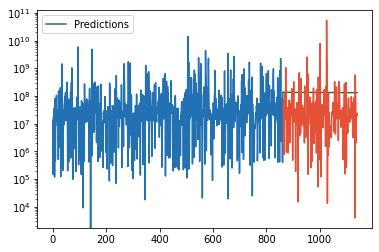

In [46]:
train = df_tsa_sum[df_tsa_sum['Date mutation'] < "2020-01-01"]['Valeur fonciere']
test = df_tsa_sum[df_tsa_sum['Date mutation'] > "2020-01-01"]['Valeur fonciere']
y = train
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]
plt.plot(y_pred_out, color='#287233', label = 'Predictions')
plt.plot(train, color = "#2271B3")
plt.plot(test, color = "#E55137")
plt.legend()
plt.yscale('log')

Prédiction ultra mauvaise !

### Machine Learning - Prédictif (pertinence ?)

In [67]:
lag = 30
X = lagmat(df_tsa_sum["diff"], lag)
lagged = df_tsa_sum.copy()
for c in range(1,lag+1):
    lagged["lag%d" % c] = X[:, c-1]
pd.concat([lagged.head(), lagged.tail()])
xc = ["lag%d" % i for i in range(1,lag+1)]
split = 0.66
isplit = int(len(lagged) * split)
xt = lagged[10:][xc]
yt = lagged[10:]["diff"]
X_train, y_train, X_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
clr = LinearRegression()
clr.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, clr.predict(X_test))
r2

0.4633873400343642